# LAPD crimes database: 2010-present

### Import data tools

In [1]:
import pandas as pd
import geopandas as gpd
import matplotlib
import matplotlib.pyplot as plt
import geojson
import json
import jenkspy
import numpy as np
from earthpy import clip as cl
from altair import datum
import altair as alt
alt.renderers.enable('notebook')
import altair_latimes as lat
alt.themes.register('latimes', lat.theme)
alt.themes.enable('latimes')
pd.options.display.max_columns = 50
pd.options.display.max_rows = 1000

### Read crimes CSV downloaded from LA City data portal

In [2]:
#https://data.lacity.org/A-Safe-City/Crime-Data-from-2010-to-Present/63jg-8b9z
src = pd.read_csv('/Users/mhustiles/data/data/LA/Crime_Data_from_2010_to_Present.csv')

In [3]:
crimes = src

In [4]:
crimes.columns = crimes.columns.str.strip().str.lower()\
.str.replace(' ', '_').str.replace('(', '').str.replace(')', '')

### These data are super messy...

In [5]:
crimes.rename(columns = { 
'dr_no':'record_id',
'date_rptd':'date_reported',
'date_occ':'date_occurred',
'time_occ':'time_occurred',
'area':'division',
'area_name':'division_name',
'rpt_dist_no':'reporting_district',
'part_1-2':'part_type',
'crm_cd':'crime_code',
'crm_cd_desc':'crime_code_description',
'mocodes':'modus_operandi_code',
'vict_age':'victim_age',
'vict_sex':'victim_sex',
'vict_descent':'victim_descent',
'premis_cd':'premises_code',
'premis_desc':'premises_description',
'weapon_used_cd':'weapon_code',
'weapon_desc':'weapon_description',
'status':'status_code',
'status_desc':'status_code_description',
'crm_cd_1':'crm_cd_1',
'crm_cd_2':'crm_cd_2',
'crm_cd_3':'crm_cd_3',
'crm_cd_4':'crm_cd_4',
'location':'address',
'cross_street':'cross_street',
'lat':'latitude',
'lon':'longitide',
 }, inplace = True)

### ... contunued

In [6]:
crimes['date_reported'] = crimes['date_reported'].str.replace(' 12:00:00 AM','')
crimes['date_occurred'] = crimes['date_occurred'].str.replace(' 12:00:00 AM','')
crimes['date_occurred'] = pd.to_datetime(crimes['date_occurred'], format='%m/%d/%Y')
crimes['year'] = crimes['date_occurred'].dt.year
crimes['quarter'] = crimes['date_occurred'].dt.quarter
crimes['day'] = crimes['date_occurred'].dt.day
crimes['month'] = crimes['date_occurred'].dt.month
crimes['weekday'] = crimes['date_occurred'].dt.weekday_name

In [7]:
crimes[[ 'record_id', 
    'time_occurred', 
    'division', 
    'reporting_district', 
    'part_type',
    'crm_cd_1',
    'crm_cd_2',
    'crm_cd_3',
    'crm_cd_4',
    'crime_code', 
    'premises_code', 
    'weapon_code',
    'year',
    'quarter',
    'day',
    'month', ]] = crimes[[
    'record_id', 
    'time_occurred', 
    'division', 
    'reporting_district', 
    'part_type',
    'crm_cd_1',
    'crm_cd_2',
    'crm_cd_3',
    'crm_cd_4',
    'crime_code', 
    'premises_code', 
    'weapon_code',
    'year',
    'quarter',
    'day',
    'month',]].astype(str)

In [8]:
descent_recode = { 'A':"Asian",'B':"Black",'C':"Asian",'D':"Asian",'F':"Asian",'G':"Asian",\
                 'H':"Hispanic",'I':"American Indian/Alaskan Native",'J':"Asian",\
                 'K':"Asian",'L':"Asian",'O':"Other",'P':"Asian",'S':"Asian",\
                 'U':"Asian",'V':"Asian",'W':"White",'X':"Other",'Z':"Asian" }

In [9]:
crimes['descent_description'] = crimes['victim_descent'].map(descent_recode)

In [10]:
crimes['premises_code'] = crimes['premises_code'].str.replace('.0','', regex=False)
crimes['premises_code'] = crimes['premises_code'].str.replace('.0','', regex=False)
crimes['crm_cd_1'] = crimes['crm_cd_1'].str.replace('.0','', regex=False)
crimes['crm_cd_2'] = crimes['crm_cd_2'].str.replace('.0','', regex=False)

In [11]:
crimes.head()

,record_id,date_reported,date_occurred,time_occurred,division,division_name,reporting_district,part_type,crime_code,crime_code_description,modus_operandi_code,victim_age,victim_sex,victim_descent,premises_code,premises_description,weapon_code,weapon_description,status_code,status_code_description,crm_cd_1,crm_cd_2,crm_cd_3,crm_cd_4,address,cross_street,latitude,longitide,year,quarter,day,month,weekday,descent_description
0,1307355,02/20/2010,2010-02-20,1350,13,Newton,1385,2,900,VIOLATION OF COURT ORDER,0913 1814 2000,48,M,H,501,SINGLE FAMILY DWELLING,nan,NaN,AA,Adult Arrest,900,nan,nan,nan,300 E GAGE AV,NaN,33.9825,-118.2695,2010,1,20,2,Saturday,Hispanic
1,11401303,09/13/2010,2010-09-12,45,14,Pacific,1485,2,740,"VANDALISM - FELONY ($400 & OVER, ALL CHURCH VA...",0329,0,M,W,101,STREET,nan,NaN,IC,Invest Cont,740,nan,nan,nan,SEPULVEDA BL,MANCHESTER AV,33.9599,-118.3962,2010,3,12,9,Sunday,White
2,70309629,08/09/2010,2010-08-09,1515,13,Newton,1324,2,946,OTHER MISCELLANEOUS CRIME,0344,0,M,H,103,ALLEY,nan,NaN,IC,Invest Cont,946,nan,nan,nan,1300 E 21ST ST,NaN,34.0224,-118.2524,2010,3,9,8,Monday,Hispanic
3,90631215,01/05/2010,2010-01-05,150,6,Hollywood,646,2,900,VIOLATION OF COURT ORDER,1100 0400 1402,47,F,W,101,STREET,102.0,HAND GUN,IC,Invest Cont,900,998,nan,nan,CAHUENGA BL,HOLLYWOOD BL,34.1016,-118.3295,2010,1,5,1,Tuesday,White
4,100100501,01/03/2010,2010-01-02,2100,1,Central,176,1,122,"RAPE, ATTEMPTED",0400,47,F,H,103,ALLEY,400.0,"STRONG-ARM (HANDS, FIST, FEET OR BODILY FORCE)",IC,Invest Cont,122,nan,nan,nan,8TH ST,SAN PEDRO ST,34.0387,-118.2488,2010,1,2,1,Saturday,Hispanic


In [12]:
crimes['time_occurred'] = crimes['time_occurred'].str.replace('.0','', regex=False)
crimes['time_occurred'] = crimes['time_occurred'].str.zfill(4)
crimes['hour'] = crimes['time_occurred'].str[:2]
crimes['minute'] = crimes['time_occurred'].str[2:]
crimes = crimes[crimes['hour'] != '0n']
crimes = crimes[crimes['hour'] != '24']

In [13]:
homicides = crimes[crimes['crime_code_description'].str.contains('CRIMINAL HOMICIDE', na=False)]

---

## Cases involving suspects or victimes defined by LAPD as 'homeless'

In [14]:
mocrimes = crimes.dropna(subset=['modus_operandi_code'])

In [15]:
mocodes = pd.read_csv('mo_codes.csv')
mocodes

,mo_code,mo_code_description
0,0100,Suspect Impersonate
1,0101,Aid victim
2,0102,Blind
3,0103,Crippled
4,0104,Customer
5,0105,Delivery
6,0106,Doctor
7,0107,God
8,0108,Infirm
9,0109,Inspector


In [16]:
# MO Code 1218 is to be used when a victim is homeless
# MO Code 2004 is to be used when a suspect is homeless
mocodes_homeless = mocodes[mocodes['mo_code_description'].str.lower().str.contains('homeless')]
mocodes_homeless.head()

,mo_code,mo_code_description
361,1218,Victim was Homeless/Transient
521,2004,Suspect is homeless/transient


In [17]:
homeless_dates = ['2015','2016', '2017', '2018', '2019']

### Various filters

In [18]:
my_street = crimes[crimes['address'].str.contains('RUBENS', na=False)]
bunco = crimes[crimes['modus_operandi_code'].str.contains('0800', na=False) ]
homeless_victims = crimes[(crimes['modus_operandi_code'].str.contains('1218', na=False)) & (crimes['year'].isin(homeless_dates))]
homeless_suspects = crimes[(crimes['modus_operandi_code'].str.contains('2004', na=False)) & (crimes['year'].isin(homeless_dates))]
homeless_homicides = homeless_victims[(homeless_victims['crime_code_description']\
                    .str.contains('CRIMINAL HOMICIDE', na=False))\
                    & (homeless_victims['year'].isin(homeless_dates))]

In [19]:
bunco.sort_values(by='date_occurred', ascending=False).head(100)

,record_id,date_reported,date_occurred,time_occurred,division,division_name,reporting_district,part_type,crime_code,crime_code_description,modus_operandi_code,victim_age,victim_sex,victim_descent,premises_code,premises_description,weapon_code,weapon_description,status_code,status_code_description,crm_cd_1,crm_cd_2,crm_cd_3,crm_cd_4,address,cross_street,latitude,longitide,year,quarter,day,month,weekday,descent_description,hour,minute
1940346,190816640,10/07/2019,2019-10-07,1225,8,West LA,829,2,664,"BUNCO, PETTY THEFT",0701 0800 0344 0121,36,F,O,501,SINGLE FAMILY DWELLING,nan,NaN,IC,Invest Cont,664,nan,nan,nan,1200 S BEVERLY GLEN BL,NaN,34.0669,-118.4288,2019,4,7,10,Monday,Other,12,25
1905334,191224252,10/07/2019,2019-10-06,1530,12,77th Street,1269,2,664,"BUNCO, PETTY THEFT",1701 0800 1402 1822,43,F,H,501,SINGLE FAMILY DWELLING,nan,NaN,IC,Invest Cont,664,nan,nan,nan,700 E 85TH ST,NaN,33.9611,-118.2629,2019,4,6,10,Sunday,Hispanic,15,30
1937797,190124476,10/06/2019,2019-10-06,1150,1,Central,195,2,664,"BUNCO, PETTY THEFT",0342 1822 1278 0800 0701,47,M,H,122,"VEHICLE, PASSENGER/TRUCK",nan,NaN,IC,Invest Cont,664,nan,nan,nan,BROADWAY,14TH ST,34.0356,-118.2625,2019,4,6,10,Sunday,Hispanic,11,50
2003005,190322165,10/05/2019,2019-10-05,1500,3,Southwest,376,2,664,"BUNCO, PETTY THEFT",0121 0701 0800 1822,53,F,H,501,SINGLE FAMILY DWELLING,nan,NaN,IC,Invest Cont,664,nan,nan,nan,3900 DALTON AV,NaN,34.0155,-118.3034,2019,4,5,10,Saturday,Hispanic,15,00
2016483,191917514,10/05/2019,2019-10-05,1200,19,Mission,1902,2,662,"BUNCO, GRAND THEFT",0344 0800 0121 1019,52,F,W,501,SINGLE FAMILY DWELLING,nan,NaN,IC,Invest Cont,662,nan,nan,nan,13700 DRONFIELD AV,NaN,34.3210,-118.4542,2019,4,5,10,Saturday,White,12,00
1910143,192017884,10/04/2019,2019-10-04,0637,20,Olympic,2027,2,664,"BUNCO, PETTY THEFT",0701 0800 0344 0100,50,M,O,203,OTHER BUSINESS,nan,NaN,IC,Invest Cont,664,nan,nan,nan,3200 W 6TH ST,NaN,34.0637,-118.2916,2019,4,4,10,Friday,Other,06,37
1924681,190219539,10/04/2019,2019-10-04,1530,2,Rampart,257,2,662,"BUNCO, GRAND THEFT",1251 0701 0800,21,F,H,502,"MULTI-UNIT DWELLING (APARTMENT, DUPLEX, ETC)",nan,NaN,IC,Invest Cont,662,nan,nan,nan,400 UNION DR,NaN,34.0592,-118.2674,2019,4,4,10,Friday,Hispanic,15,30
1912561,190816471,10/03/2019,2019-10-03,1200,8,West LA,839,2,664,"BUNCO, PETTY THEFT",1202 0344 0701 0800 0121,75,M,A,501,SINGLE FAMILY DWELLING,nan,NaN,IC,Invest Cont,664,nan,nan,nan,10200 CENTURY WOODS DR,NaN,34.0552,-118.4154,2019,4,3,10,Thursday,Asian,12,00
2044640,192116606,10/03/2019,2019-10-03,1300,21,Topanga,2158,2,664,"BUNCO, PETTY THEFT",0800,54,F,O,501,SINGLE FAMILY DWELLING,nan,NaN,IC,Invest Cont,664,nan,nan,nan,20800 EXHIBIT CT,NaN,34.1786,-118.5854,2019,4,3,10,Thursday,Other,13,00
1943696,190124391,10/04/2019,2019-10-03,1630,1,Central,182,2,662,"BUNCO, GRAND THEFT",0800 0701 1822,23,F,B,502,"MULTI-UNIT DWELLING (APARTMENT, DUPLEX, ETC)",511.0,VERBAL THREAT,IC,Invest Cont,662,nan,nan,nan,1000 S OLIVE ST,NaN,34.0423,-118.2595,2019,4,3,10,Thursday,Black,16,30


In [20]:
len(bunco)

6837

In [21]:
len(homeless_victims)

16168

In [22]:
len(homeless_suspects)

33843

In [23]:
homeless_homicides

,record_id,date_reported,date_occurred,time_occurred,division,division_name,reporting_district,part_type,crime_code,crime_code_description,modus_operandi_code,victim_age,victim_sex,victim_descent,premises_code,premises_description,weapon_code,weapon_description,status_code,status_code_description,crm_cd_1,crm_cd_2,crm_cd_3,crm_cd_4,address,cross_street,latitude,longitide,year,quarter,day,month,weekday,descent_description,hour,minute
1041598,151511171,05/09/2015,2015-05-09,1340,15,N Hollywood,1525,1,110,CRIMINAL HOMICIDE,0430 1100 0906 1402 1420 0449 0529 1809 1218 1414,25,M,H,247,CAR WASH,101.0,REVOLVER,AA,Adult Arrest,110,nan,nan,nan,6400 LAUREL CANYON BL,NaN,34.1867,-118.3965,2015,2,9,5,Saturday,Hispanic,13,40
1041815,150118604,08/11/2015,2015-08-11,0144,1,Central,147,1,110,CRIMINAL HOMICIDE,1218 1100 0430 1202,60,M,B,102,SIDEWALK,102.0,HAND GUN,AA,Adult Arrest,110,nan,nan,nan,300 E 5TH ST,NaN,34.0453,-118.2443,2015,3,11,8,Tuesday,Black,01,44
1043108,151507992,03/11/2015,2015-03-11,1115,15,N Hollywood,1532,1,110,CRIMINAL HOMICIDE,1310 0350 1218,48,M,W,101,STREET,500.0,UNKNOWN WEAPON/OTHER WEAPON,IC,Invest Cont,110,nan,nan,nan,12300 SYLVAN ST,NaN,34.1849,-118.4025,2015,1,11,3,Wednesday,White,11,15
1067343,150222118,12/07/2015,2015-12-06,2200,2,Rampart,217,1,110,CRIMINAL HOMICIDE,1402 0411 1218,66,M,B,102,SIDEWALK,200.0,KNIFE WITH BLADE 6INCHES OR LESS,IC,Invest Cont,110,998,nan,nan,ALVARADO ST,BELLEVUE AV,34.0729,-118.2664,2015,4,6,12,Sunday,Black,22,00
1088340,151423154,08/30/2015,2015-08-30,0209,14,Pacific,1412,1,110,CRIMINAL HOMICIDE,1218 1100 0906 0430 1409 1407 1402,26,M,B,102,SIDEWALK,102.0,HAND GUN,AA,Adult Arrest,110,998,nan,nan,300 OCEAN FRONT WK,NaN,33.9933,-118.4765,2015,3,30,8,Sunday,Black,02,09
1100359,151100762,07/04/2015,2015-07-04,1945,11,Northeast,1119,1,110,CRIMINAL HOMICIDE,0411 0416 0400 1218 1402,53,M,W,101,STREET,500.0,UNKNOWN WEAPON/OTHER WEAPON,AA,Adult Arrest,110,998,nan,nan,N FIGUEROA ST,LA LOMA RD,34.1367,-118.1881,2015,3,4,7,Saturday,White,19,45
1104613,151414648,05/16/2015,2015-05-16,1415,14,Pacific,1487,1,110,CRIMINAL HOMICIDE,1218 2004 1402 1820,26,M,W,101,STREET,500.0,UNKNOWN WEAPON/OTHER WEAPON,AA,Adult Arrest,110,998,nan,nan,LA TIJERA BL,SEPULVEDA BL,33.9573,-118.3962,2015,2,16,5,Saturday,White,14,15
1120354,150110280,04/06/2015,2015-04-06,0754,1,Central,156,1,110,CRIMINAL HOMICIDE,1218 0907 2004 0411,38,M,W,516,SINGLE RESIDENCE OCCUPANCY (SRO'S) LOCATIONS,207.0,OTHER KNIFE,AA,Adult Arrest,110,nan,nan,nan,500 SAN JULIAN ST,NaN,34.0446,-118.2450,2015,2,6,4,Monday,White,07,54
1123772,150106378,02/08/2015,2015-02-07,1940,1,Central,111,1,110,CRIMINAL HOMICIDE,2004 1218 0416 0417,48,M,B,108,PARKING LOT,400.0,"STRONG-ARM (HANDS, FIST, FEET OR BODILY FORCE)",AA,Adult Arrest,110,nan,nan,nan,700 W CESAR E CHAVEZ AV,NaN,34.0606,-118.2439,2015,1,7,2,Saturday,Black,19,40
1149144,150506085,02/17/2015,2015-02-16,2100,5,Harbor,526,1,110,CRIMINAL HOMICIDE,0430 1822 1100 1218,56,M,W,108,PARKING LOT,106.0,UNKNOWN FIREARM,IC,Invest Cont,110,nan,nan,nan,300 W ANAHEIM ST,NaN,33.7799,-118.2650,2015,1,16,2,Monday,White,21,00


In [24]:
homeless_homicides_years = homeless_homicides.groupby(['year','division_name']).agg('size').reset_index(name='total')

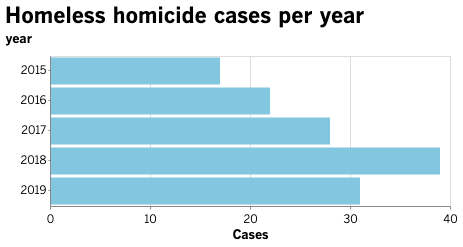

In [25]:
alt.Chart(homeless_homicides_years).mark_bar().encode(
    y=alt.Y('year:N', axis=alt.Axis(format='', tickCount=5)),
    x=alt.X("sum(total):Q", title="Cases", axis=alt.Axis(format='', tickCount=5))
).properties(height=150, width=400, columns=3, title='Homeless homicide cases per year')

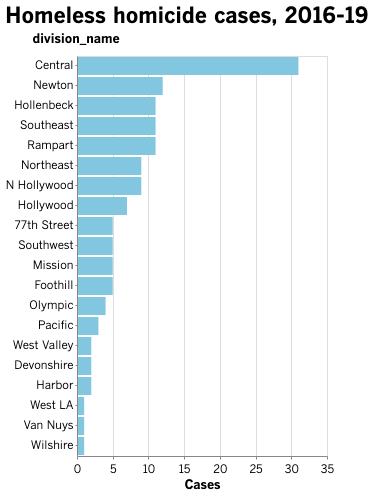

In [26]:
alt.Chart(homeless_homicides_years).mark_bar().encode(
    y=alt.Y('division_name:N',
        sort=alt.EncodingSortField(
            field="total",  # The field to use for the sort
            op="sum",  # The operation to run on the field prior to sorting
            order="descending"  # The order to sort in
        ), axis=alt.Axis(format='', tickCount=5)),
    x=alt.X("sum(total):Q", title="Cases", axis=alt.Axis(format='', tickCount=5))
).properties(height=400, width=250, columns=3, title='Homeless homicide cases, 2016-19')

---

In [27]:
homeless_year_victim = homeless_victims.groupby(['year', 'division_name'])\
.agg('size').reset_index(name='total').sort_values(by='total', ascending=False)
homeless_year_victim.head()

,year,division_name,total
85,2019,Central,1560
64,2018,Central,1404
1,2015,Central,922
22,2016,Central,807
43,2017,Central,677


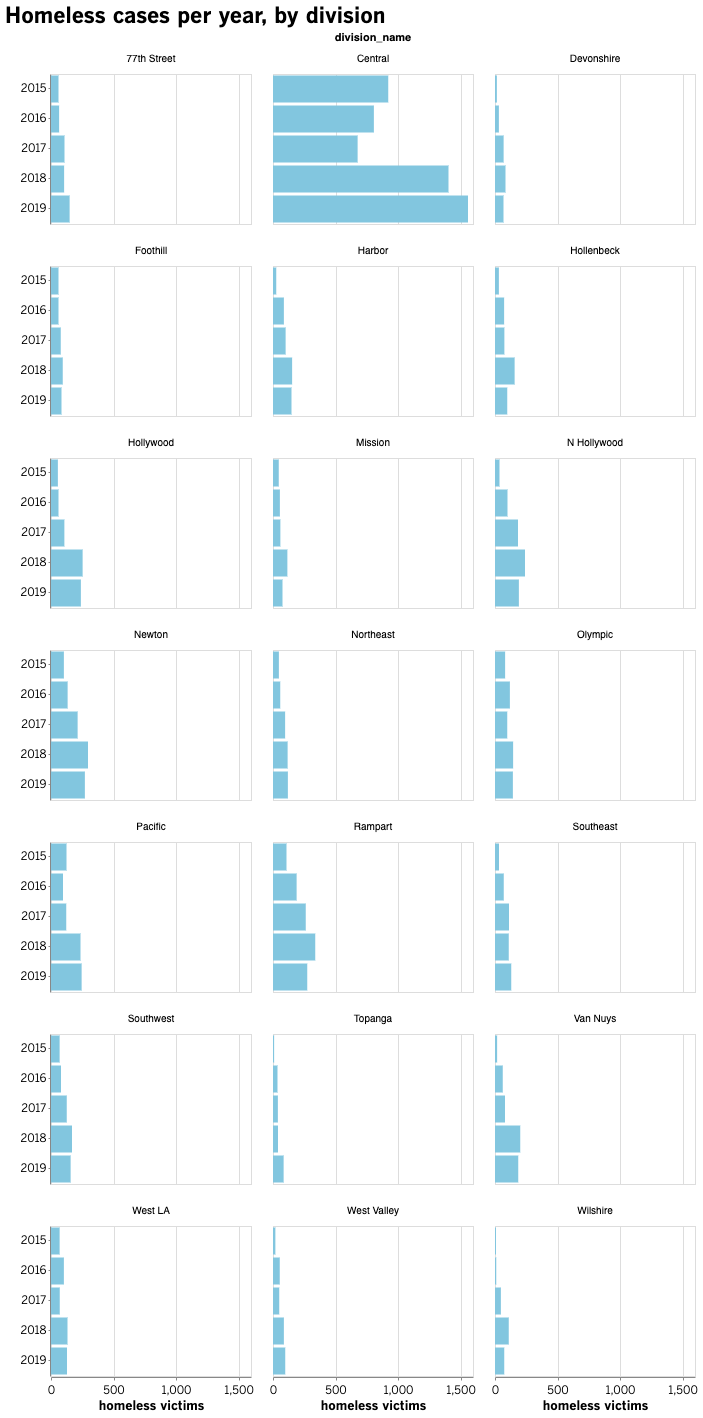

In [28]:
alt.Chart(homeless_year_victim).mark_bar().encode(
    y=alt.Y('year:N', title='', axis=alt.Axis(format='', tickCount=5)),
    x=alt.X("sum(total):Q", title="homeless victims", axis=alt.Axis(format='', tickCount=5)),
    facet='division_name:N'
).properties(height=150, width=200, columns=3, title='Homeless cases per year, by division')

---

In [29]:
homeless_year_victim = homeless_victims.groupby(['year', 'division_name', 'status_code_description'])\
.agg('size').reset_index(name='total').sort_values(by='total', ascending=False)
homeless_year_victim.head()

,year,division_name,status_code_description,total
265,2019,Central,Invest Cont,1276
196,2018,Central,Invest Cont,1090
5,2015,Central,Invest Cont,709
65,2016,Central,Invest Cont,593
130,2017,Central,Invest Cont,535


---

In [30]:
homeless_cases_victim = homeless_victims.groupby(['crime_code_description'])\
.agg('size').reset_index(name='total').sort_values(by='total', ascending=False)

In [31]:
homeless_cases_victim.head(10)

,crime_code_description,total
2,"ASSAULT WITH DEADLY WEAPON, AGGRAVATED ASSAULT",3993
4,BATTERY - SIMPLE ASSAULT,2916
55,ROBBERY,1810
69,THEFT PLAIN - PETTY ($950 & UNDER),1664
37,INTIMATE PARTNER - SIMPLE ASSAULT,1632
36,INTIMATE PARTNER - AGGRAVATED ASSAULT,666
53,"RAPE, FORCIBLE",450
9,BRANDISH WEAPON,415
24,CRIMINAL THREATS - NO WEAPON DISPLAYED,324
3,ATTEMPTED ROBBERY,249


In [32]:
homeless_cases_suspect = homeless_suspects.groupby(['crime_code_description'])\
.agg('size').reset_index(name='total').sort_values(by='total', ascending=False)

In [33]:
homeless_cases_suspect.head(100)

,crime_code_description,total
2,"ASSAULT WITH DEADLY WEAPON, AGGRAVATED ASSAULT",4745
4,BATTERY - SIMPLE ASSAULT,4592
97,TRESPASSING,2823
76,ROBBERY,2713
80,SHOPLIFTING - PETTY THEFT ($950 & UNDER),2520
55,INTIMATE PARTNER - SIMPLE ASSAULT,1978
99,"VANDALISM - FELONY ($400 & OVER, ALL CHURCH VA...",1476
90,THEFT PLAIN - PETTY ($950 & UNDER),1226
32,CRIMINAL THREATS - NO WEAPON DISPLAYED,1138
14,BURGLARY,1127


--- 

## Basic aggregates on variables for all crimes

### Which crimes are most common? 

In [34]:
violations = crimes.groupby(['crime_code_description'])\
.agg('size').reset_index(name='total').sort_values(by='total', ascending=False)

In [35]:
violations.head(10)

,crime_code_description,total
5,BATTERY - SIMPLE ASSAULT,186258
22,BURGLARY FROM VEHICLE,158076
136,VEHICLE - STOLEN,155886
118,THEFT PLAIN - PETTY ($950 & UNDER),145922
21,BURGLARY,144417
116,THEFT OF IDENTITY,123666
75,INTIMATE PARTNER - SIMPLE ASSAULT,111737
132,"VANDALISM - FELONY ($400 & OVER, ALL CHURCH VA...",106437
3,"ASSAULT WITH DEADLY WEAPON, AGGRAVATED ASSAULT",90253
133,VANDALISM - MISDEAMEANOR ($399 OR UNDER),88706


### Places where crimes occur?

In [36]:
places = crimes.groupby(['premises_description'])\
.agg('size').reset_index(name='total').sort_values(by='total', ascending=False)

In [37]:
places.head(100)

,premises_description,total
278,STREET,460268
267,SINGLE FAMILY DWELLING,417089
211,"MULTI-UNIT DWELLING (APARTMENT, DUPLEX, ETC)",259047
233,PARKING LOT,146035
266,SIDEWALK,103165
224,OTHER BUSINESS,93916
311,"VEHICLE, PASSENGER/TRUCK",77786
64,DRIVEWAY,41592
80,GARAGE/CARPORT,36703
258,RESTAURANT/FAST FOOD,28372


### Areas of the city? 

In [38]:
divisions = crimes.groupby(['division_name'])\
.agg('size').reset_index(name='total').sort_values(by='total', ascending=False)

In [39]:
divisions.head(21)

,division_name,total
0,77th Street,141789
15,Southwest,132019
8,N Hollywood,110990
12,Pacific,109399
14,Southeast,108601
7,Mission,101132
10,Northeast,97774
9,Newton,97291
17,Van Nuys,97091
6,Hollywood,96124


### What kinds of weapons?

In [40]:
weapons = crimes.groupby(['weapon_description'])\
.agg('size').reset_index(name='total').sort_values(by='total', ascending=False)

In [41]:
weapons.head(10)

,weapon_description,total
65,"STRONG-ARM (HANDS, FIST, FEET OR BODILY FORCE)",419123
78,VERBAL THREAT,57214
75,UNKNOWN WEAPON/OTHER WEAPON,55699
27,HAND GUN,33231
58,SEMI-AUTOMATIC PISTOL,12644
32,KNIFE WITH BLADE 6INCHES OR LESS,12488
44,OTHER KNIFE,9505
73,UNKNOWN FIREARM,7713
77,VEHICLE,7065
50,REVOLVER,5490


### Which days of the week?

In [42]:
weekdays = crimes.groupby(['weekday'])\
.agg('size').reset_index(name='total').sort_values(by='total', ascending=False)

In [43]:
weekdays.head(7)

,weekday,total
0,Friday,316569
2,Saturday,296240
1,Monday,293367
6,Wednesday,291420
4,Thursday,289866
5,Tuesday,287415
3,Sunday,283341


### UCR type?

In [44]:
crimes['part_type'].value_counts('normalize').round(2)*100

1    55.0
2    45.0
Name: part_type, dtype: float64

---

### Cleaning up modus operandi

In [45]:
crimes.dtypes

record_id                          object
date_reported                      object
date_occurred              datetime64[ns]
time_occurred                      object
division                           object
division_name                      object
reporting_district                 object
part_type                          object
crime_code                         object
crime_code_description             object
modus_operandi_code                object
victim_age                          int64
victim_sex                         object
victim_descent                     object
premises_code                      object
premises_description               object
weapon_code                        object
weapon_description                 object
status_code                        object
status_code_description            object
crm_cd_1                           object
crm_cd_2                           object
crm_cd_3                           object
crm_cd_4                          

In [59]:
df = crimes[['record_id', 'modus_operandi_code']]

In [60]:
df['modus_operandi_code'] = df['modus_operandi_code'].dropna().apply(lambda x: x.split(' '))

//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [62]:
final = df['modus_operandi_code'].apply(pd.Series)\
.merge(df, left_index = True, right_index = True)\
.drop('modus_operandi_code', axis = 1)\
.melt(id_vars = ['record_id'], value_name = "modus_operandi_code", var_name = 'modoporder')\
.dropna(subset=['modus_operandi_code'])\
.sort_values('record_id')

In [68]:
mo_counts = final.groupby(['modus_operandi_code']).agg('size')\
.reset_index(name='count').sort_values(by='count', ascending=False)

In [69]:
mo_counts.merge()

,modus_operandi_code,count
88,0344,681417
160,0416,275320
73,0329,239520
521,1822,193010
541,2000,176649
144,0400,134106
279,0913,118503
423,1300,116875
443,1402,114868
494,1609,85676


In [70]:
merged_mo_counts = pd.merge(mo_counts, mocodes, 
                     left_on = 'modus_operandi_code', 
                     right_on = 'mo_code', 
                     how='left')

In [72]:
merged_mo_counts.head()

,modus_operandi_code,count,mo_code,mo_code_description
0,0344,681417,0344,Removes vict property
1,0416,275320,0416,Hit-Hit w/ weapon
2,0329,239520,0329,Vandalized
3,1822,193010,1822,Stranger
4,2000,176649,2000,Domestic violence
